# Análisis exploratorio - Censo 2017 Chile

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pyarrow as pa
from sklearn.linear_model import LinearRegression

## Carga de base de datos

La base de datos original viene comprimida en formato csv. Descomprimido el archivo pesa 2,5 GB, lo que hace muy pesada la carga. Para ello, primero la cargamos en su formato original, luego es transformada al formato .parquet con el paquete pyarrow

### Datos originales

In [ ]:
# Se carga el dataset total del censo en csv con chunks para facilitar procesamiento
chunk_size = 5000

chunky = pd.read_csv('C:/Users/benja/OneDrive - Instituto Nacional de Estadisticas/PAECIS/TIF/CENSO 17/Microdato_Censo2017-Personas.csv', sep=';', chunksize=chunk_size)

In [ ]:
# se unen los chunks en una sola base
censo_17 = pd.concat(chunky)

In [ ]:
censo_17.head()

,REGION,PROVINCIA,COMUNA,DC,AREA,ZC_LOC,ID_ZONA_LOC,NVIV,NHOGAR,PERSONAN,...,P11PAIS_GRUPO,P12PAIS_GRUPO,ESCOLARIDAD,P16A_GRUPO,REGION_15R,PROVINCIA_15R,COMUNA_15R,P10COMUNA_15R,P11COMUNA_15R,P12COMUNA_15R
0,15,152,15202,1,2,6,13225,1,1,1,...,998,998,4,2,15,152,15202,98,15101,98
1,15,152,15202,1,2,6,13225,3,1,1,...,998,998,0,2,15,152,15202,98,98,98
2,15,152,15202,1,2,6,13225,3,1,2,...,998,998,0,2,15,152,15202,98,98,98
3,15,152,15202,1,2,6,13225,3,1,3,...,998,998,2,2,15,152,15202,98,98,98
4,15,152,15202,1,2,6,13225,3,1,4,...,998,998,3,2,15,152,15202,98,98,98


In [ ]:
censo_17.keys()

Index(['REGION', 'PROVINCIA', 'COMUNA', 'DC', 'AREA', 'ZC_LOC', 'ID_ZONA_LOC',
       'NVIV', 'NHOGAR', 'PERSONAN', 'P07', 'P08', 'P09', 'P10', 'P10COMUNA',
       'P10PAIS', 'P11', 'P11COMUNA', 'P11PAIS', 'P12', 'P12COMUNA', 'P12PAIS',
       'P12A_LLEGADA', 'P12A_TRAMO', 'P13', 'P14', 'P15', 'P15A', 'P16',
       'P16A', 'P16A_OTRO', 'P17', 'P18', 'P19', 'P20', 'P21M', 'P21A',
       'P10PAIS_GRUPO', 'P11PAIS_GRUPO', 'P12PAIS_GRUPO', 'ESCOLARIDAD',
       'P16A_GRUPO', 'REGION_15R', 'PROVINCIA_15R', 'COMUNA_15R',
       'P10COMUNA_15R', 'P11COMUNA_15R', 'P12COMUNA_15R'],
      dtype='object')

### Transformación a parquet y carga

In [ ]:
#Se transforma el dataframe de pandas a formato parquet.
censo_pq = pa.Table.from_pandas(censo_17)

In [ ]:
# Se guarda el dataset en formato parquet
pq.write_table(censo_pq, 'C:/Users/benja/OneDrive - Instituto Nacional de Estadisticas/PAECIS/TIF/CENSO 17/Microdato_Censo2017-Personas.parquet')

In [ ]:
del censo_17

In [ ]:
# Se lee nuevamente el dataset, esta vez el tiempo de carga se reduce considerablemente.
censo_17 = pq.read_table('C:/Users/benja/OneDrive - Instituto Nacional de Estadisticas/PAECIS/TIF/CENSO 17/Microdato_Censo2017-Personas.parquet').to_pandas()

In [ ]:
censo_17.head()

,REGION,PROVINCIA,COMUNA,DC,AREA,ZC_LOC,ID_ZONA_LOC,NVIV,NHOGAR,PERSONAN,...,P11PAIS_GRUPO,P12PAIS_GRUPO,ESCOLARIDAD,P16A_GRUPO,REGION_15R,PROVINCIA_15R,COMUNA_15R,P10COMUNA_15R,P11COMUNA_15R,P12COMUNA_15R
0,15,152,15202,1,2,6,13225,1,1,1,...,998,998,4,2,15,152,15202,98,15101,98
1,15,152,15202,1,2,6,13225,3,1,1,...,998,998,0,2,15,152,15202,98,98,98
2,15,152,15202,1,2,6,13225,3,1,2,...,998,998,0,2,15,152,15202,98,98,98
3,15,152,15202,1,2,6,13225,3,1,3,...,998,998,2,2,15,152,15202,98,98,98
4,15,152,15202,1,2,6,13225,3,1,4,...,998,998,3,2,15,152,15202,98,98,98


In [ ]:
#Se seleccionan solo las variables de interés: Comuna, edad, escolaridad y sexo.

censo_17 = censo_17[['COMUNA', 'P08', 'P09', 'P13', 'P14', 'P15', 'P15A', 'ESCOLARIDAD']]

## Exploración Censo

### Censo completo

In [ ]:
FREC_ESC= censo_17.value_counts(subset='ESCOLARIDAD')

FREC_ESC.sort_index()

ESCOLARIDAD
0     1882834
1      342840
2      390050
3      485038
4      551347
5      464959
6      805990
7      480776
8     1345103
9      608218
10     922644
11     589371
12    4189839
13     334841
14     699575
15     709520
16     599405
17    1346449
18      24652
19     169194
20      19094
21      31749
99     580515
dtype: int64

In [ ]:
ESC_COMUNA = censo_17.groupby(by='COMUNA').mean('ESCOLARIDAD').reset_index()[['COMUNA', 'ESCOLARIDAD']].sort_values(by = 'COMUNA')

In [ ]:
ESC_COMUNA.head()

,COMUNA,ESCOLARIDAD
0,1101,12.630883
1,1107,12.228614
2,1401,11.755394
3,1402,15.192000
4,1403,15.864583


In [ ]:
ESC_COMUNA.to_csv('C:/Users/benja/OneDrive - Instituto Nacional de Estadisticas/PAECIS/TIF/Salidas C17/escolaridad_comuna.csv')

In [ ]:
EDAD_COMUNA = censo_17.groupby(by='COMUNA').mean('P09').reset_index()[['COMUNA', 'P09']].sort_values(by = 'COMUNA')

In [ ]:
EDAD_COMUNA.head()

,COMUNA,P09
0,1101,34.304349
1,1107,28.791649
2,1401,32.163580
3,1402,37.286400
4,1403,37.019097


In [ ]:
EDAD_COMUNA.to_csv('C:/Users/benja/OneDrive - Instituto Nacional de Estadisticas/PAECIS/TIF/Salidas C17/edad_comuna.csv')

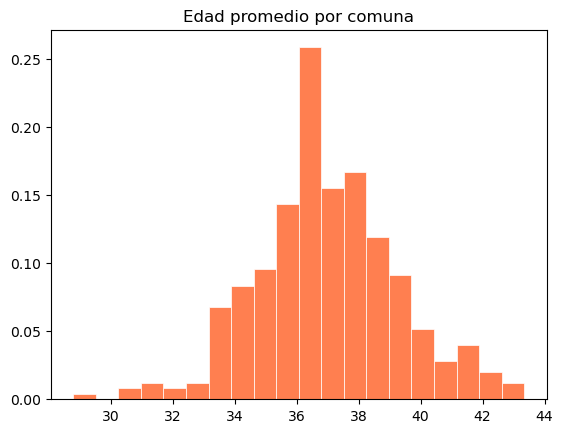

In [ ]:
fig, ax = plt.subplots()

ax.hist(EDAD_COMUNA['P09'], 20, facecolor = 'coral', linewidth = 0.5, edgecolor = 'white', density=True)
ax.set_title('Edad promedio por comuna')
plt.show()

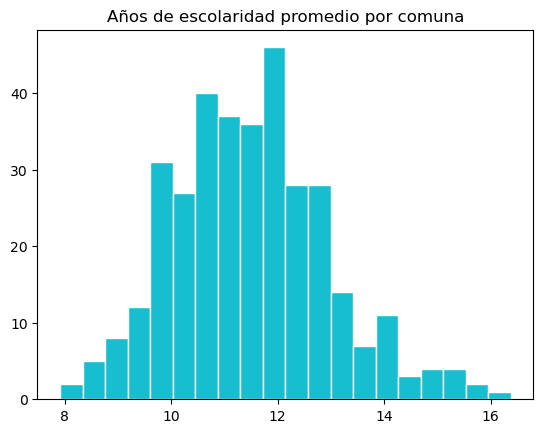

In [ ]:
fig, ax = plt.subplots()

ax.hist(ESC_COMUNA['ESCOLARIDAD'], 20, facecolor = 'tab:cyan', edgecolor = 'white')
ax.set_title('Años de escolaridad promedio por comuna')
plt.show()


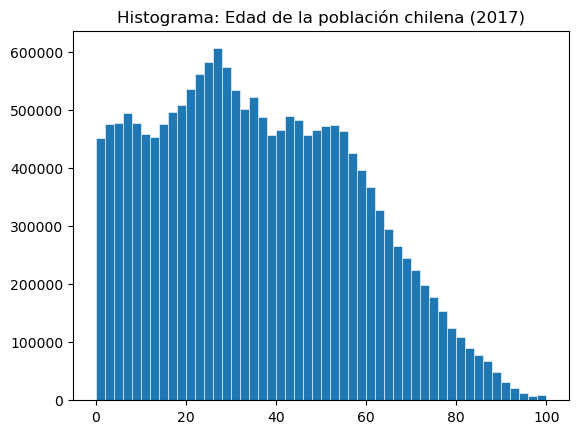

In [ ]:
fig, ax = plt.subplots()

ax.hist(censo_17['P09'], 50, edgecolor = '1', linewidth = 0.4)
ax.set_title('Histograma: Edad de la población chilena (2017)')
plt.show()

In [ ]:
esc_rec = censo_17['ESCOLARIDAD']

In [ ]:
esc_rec = esc_rec.replace(to_replace=99, value=np.NaN)

In [ ]:
esc_rec.describe()

count    1.699349e+07
mean     9.386473e+00
std      5.264380e+00
min      0.000000e+00
25%      6.000000e+00
50%      1.100000e+01
75%      1.200000e+01
max      2.100000e+01
Name: ESCOLARIDAD, dtype: float64

In [ ]:
sumary_esc = esc_rec.value_counts().sort_index()

sumary_esc


0.0     1882834
1.0      342840
2.0      390050
3.0      485038
4.0      551347
5.0      464959
6.0      805990
7.0      480776
8.0     1345103
9.0      608218
10.0     922644
11.0     589371
12.0    4189839
13.0     334841
14.0     699575
15.0     709520
16.0     599405
17.0    1346449
18.0      24652
19.0     169194
20.0      19094
21.0      31749
Name: ESCOLARIDAD, dtype: int64

In [ ]:
sumary_esc.values

array([1882834,  342840,  390050,  485038,  551347,  464959,  805990,
        480776, 1345103,  608218,  922644,  589371, 4189839,  334841,
        699575,  709520,  599405, 1346449,   24652,  169194,   19094,
         31749], dtype=int64)

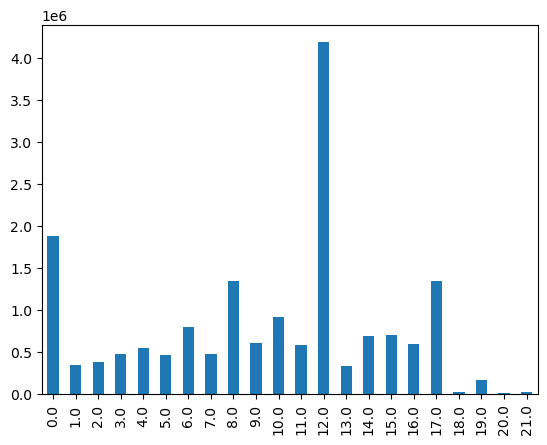

In [ ]:
sumary_esc.plot.bar()
plt.show()

In [ ]:
esc_edad = pd.merge(ESC_COMUNA, EDAD_COMUNA, how='inner', on='COMUNA')

In [ ]:
esc_edad.head()

,COMUNA,ESCOLARIDAD,P09
0,1101,12.630883,34.304349
1,1107,12.228614,28.791649
2,1401,11.755394,32.163580
3,1402,15.192000,37.286400
4,1403,15.864583,37.019097


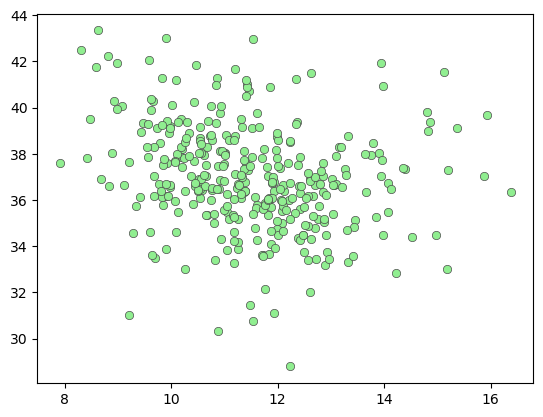

In [ ]:
fig, ax = plt.subplots()

ax.scatter(x = esc_edad['ESCOLARIDAD'], y = esc_edad['P09'], facecolor = "lightgreen", edgecolors='0.3', linewidths=0.5)
plt.show()

In [ ]:
np.corrcoef(esc_edad['ESCOLARIDAD'], esc_edad['P09'])

array([[ 1.        , -0.22762006],
       [-0.22762006,  1.        ]])

In [ ]:
censo_17['hom'] = np.where(censo_17['P08'] == 1, 1, 0)

In [ ]:
sum(censo_17['hom'])

8601989

In [ ]:
porc_hom = censo_17.groupby('COMUNA').mean('hom').reset_index()[['COMUNA', 'P08']]

In [ ]:
porc_hom['P08'] = porc_hom['P08'] - 1

In [ ]:
porc_hom

,COMUNA,P08
0,1101,0.504371
1,1107,0.499829
2,1401,0.427980
3,1402,0.474400
4,1403,0.424190
...,...,...
341,16301,0.520500
342,16302,0.500614
343,16303,0.496413
344,16304,0.488626


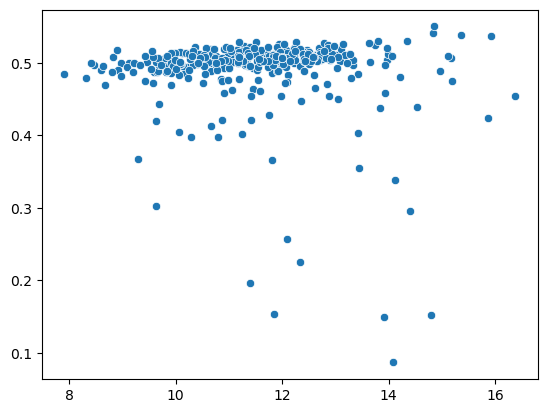

In [ ]:
fig, ax = plt.subplots()

ax.scatter(x = esc_edad['ESCOLARIDAD'], y = porc_hom['P08'], edgecolors='1', linewidths=0.5)

plt.show()

### Subset población adulta

Hasta ahora se trabajó con la base completa, pero para analizar el fenómeno político es importante considerar que es la población adulta la que incide, y altera también indicadores como la escolaridad.

In [ ]:
# Filtramos la base con la población sobre 18 años
censo_adult = censo_17.query('P09 >= 18')

In [ ]:
# Creamos una variable de escolaridad recodificada, eliminando los números 99 que representan datos perdidos.

censo_adult['esc_rec'] = censo_adult['ESCOLARIDAD'].replace(to_replace = 99, value = np.NaN)

C:\Users\benja\AppData\Local\Temp\ipykernel_15816\3254188173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censo_adult['esc_rec'] = censo_adult['ESCOLARIDAD'].replace(to_replace = 99, value = np.NaN)


In [ ]:
# Se promedian los años de escolaridad por comuna.

nivel_ed = censo_adult.groupby('COMUNA').mean('esc_rec').reset_index()[['COMUNA', 'esc_rec']]

In [ ]:
nivel_ed

,COMUNA,esc_rec
0,1101,12.206611
1,1107,10.566225
2,1401,10.756886
3,1402,8.372503
4,1403,8.653282
...,...,...
341,16301,9.480996
342,16302,8.825410
343,16303,8.133293
344,16304,8.798042


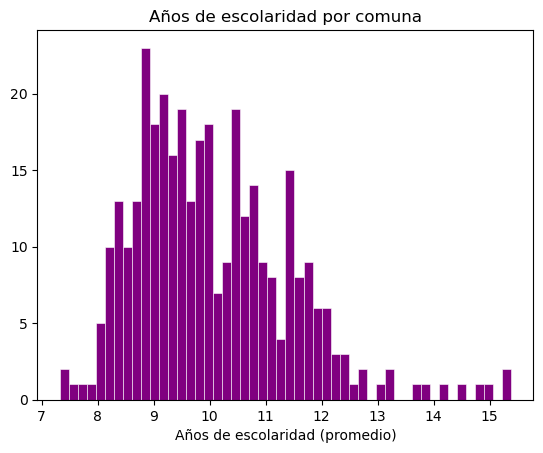

In [ ]:
fig, ax = plt.subplots()

ax.hist(nivel_ed['esc_rec'], 50, edgecolor = '1', linewidth = 0.4, facecolor = 'purple')
ax.set_title('Años de escolaridad por comuna')
ax.set_xlabel('Años de escolaridad (promedio)')
plt.show()

In [ ]:
#Se promedia la edad por comuna
edades = censo_adult.groupby('COMUNA').mean('P09').reset_index()[['COMUNA', 'P09']]

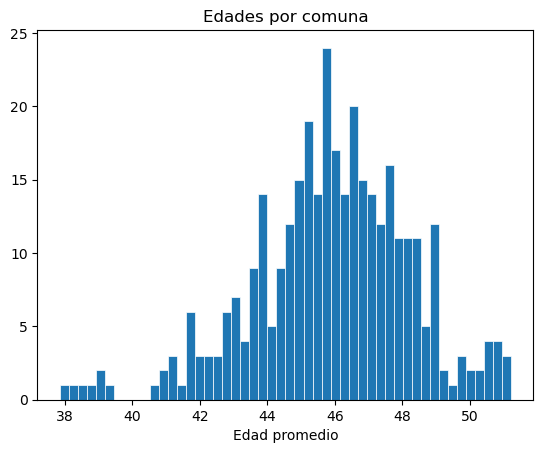

In [ ]:
fig, ax = plt.subplots()

ax.hist(edades['P09'], bins=50, edgecolor = '1', linewidth = 0.5)
ax.set_title('Edades por comuna')
ax.set_xlabel('Edad promedio')
plt.show()

De forma exploratoria, intentamos caracterizar la relación entre la edad y la escolaridad, a nivel de comunas. Para ello realizamos una regresión lineal donde la variable independiente será la escolaridad y la dependiente la edad.

In [ ]:
x = nivel_ed['esc_rec']
x = np.array(x).reshape((-1,1))

y = edades['P09']

model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [ ]:
r2 = model.score(x,y)
coeff = model.coef_
intercept = model.intercept_

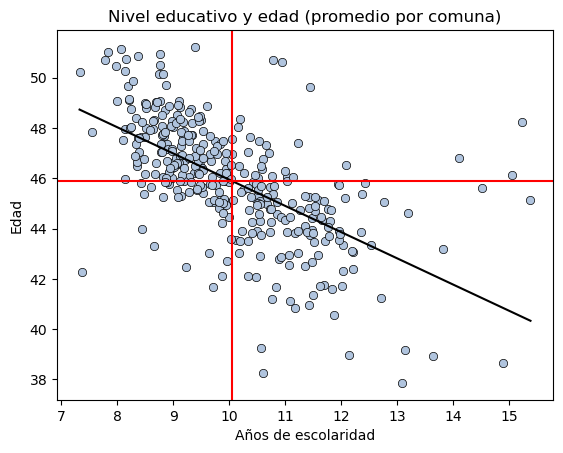

In [ ]:
fig, ax = plt.subplots()

ax.scatter(x=nivel_ed['esc_rec'], y=edades['P09'], facecolor = 'lightsteelblue', edgecolors='0', linewidths=0.5)

num = len(nivel_ed)
start = nivel_ed['esc_rec'].min()
end = nivel_ed['esc_rec'].max()
xseq = np.linspace(start, end, num=num)

ax.plot(xseq, intercept+coeff[0]*xseq, color = 'black', lw = 1.5)
plt.axvline(x=nivel_ed['esc_rec'].mean(),  color = 'r')
plt.axhline(y=edades['P09'].mean(), color = 'r')

ax.set_title('Nivel educativo y edad (promedio por comuna)')
ax.set_xlabel('Años de escolaridad')
ax.set_ylabel('Edad')

plt.show()

In [ ]:
edades['P09'].corr(nivel_ed['esc_rec'], method='pearson')

-0.6094293645613259

In [ ]:
censo_adult.value_counts(subset = 'esc_rec').sort_index()

esc_rec
0.0      295151
1.0       90889
2.0      149166
3.0      254301
4.0      324740
5.0      240218
6.0      580612
7.0      257821
8.0     1095046
9.0      384581
10.0     718663
11.0     436345
12.0    4189839
13.0     334841
14.0     699575
15.0     709520
16.0     599405
17.0    1346449
18.0      24652
19.0     169194
20.0      19094
21.0      31749
dtype: int64

Posteriormente se prepara el dataset para realizar una matriz de correlación

In [ ]:
censo_paracorr = censo_adult[['COMUNA', 'P08', 'P09', 'esc_rec']]
censo_paracorr['hom'] = np.where(censo_paracorr['P08'] == 1, 1, 0)

#censo_paracorr.head()

censo_paracorr = censo_paracorr.groupby('COMUNA').agg('mean').reset_index().drop(columns = ['COMUNA','P08'])

corr_mat = censo_paracorr.corr()

C:\Users\benja\AppData\Local\Temp\ipykernel_15816\2898121761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censo_paracorr['hom'] = np.where(censo_paracorr['P08'] == 1, 1, 0)


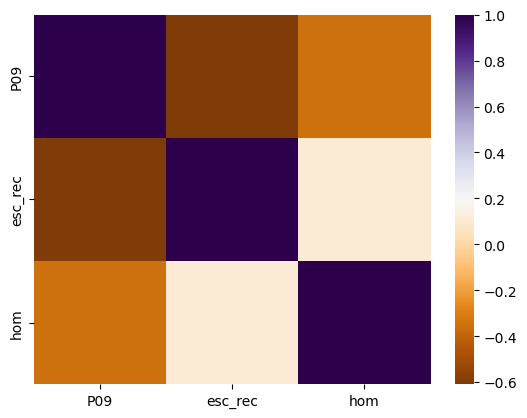

In [ ]:
import seaborn as sns

sns.heatmap(corr_mat, cmap='PuOr')

plt.show()

Finalmente se prepara una nueva versión del dataset que quede disponible para unirse con los datos electorales.

In [ ]:
censo_union = censo_adult.groupby('COMUNA').agg('mean').reset_index()

In [ ]:
censo_union = censo_union.drop(columns=['P13', 'P14', 'P15', 'P15A', 'ESCOLARIDAD'])

In [ ]:
censo_union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   COMUNA   346 non-null    int64  
 1   P08      346 non-null    float64
 2   P09      346 non-null    float64
 3   hom      346 non-null    float64
 4   esc_rec  346 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


## Datos electorales Chile

In [ ]:
# Cargamos los resultados electorales por comuna
voto_com = pd.read_excel('C:/Users/benja/OneDrive - Instituto Nacional de Estadisticas/PAECIS/TIF/Servel Chile/2021_11_Presidencial_1V_Datos_Eleccion.xlsx',
                         sheet_name='Votación comunal en Chile', skiprows=6)

In [ ]:
voto_com.head()

,Nro Región,Región,Circunscripción senatorial,Distrito,Comuna,Nro.Voto,Nombres,Primer Apellido,Segundo Apellido,Votos,Nominado
0,1,DE TARAPACA,CIRCUNSCRIPCION SENATORIAL 2,DISTRITO 2,ALTO HOSPICIO,1.0,GABRIEL,BORIC,FONT,3183,SELECCIONADO SEGUNDA VOTACION
1,1,DE TARAPACA,CIRCUNSCRIPCION SENATORIAL 2,DISTRITO 2,ALTO HOSPICIO,2.0,JOSE ANTONIO,KAST,RIST,5860,SELECCIONADO SEGUNDA VOTACION
2,1,DE TARAPACA,CIRCUNSCRIPCION SENATORIAL 2,DISTRITO 2,ALTO HOSPICIO,3.0,YASNA,PROVOSTE,CAMPILLAY,2212,NaN
3,1,DE TARAPACA,CIRCUNSCRIPCION SENATORIAL 2,DISTRITO 2,ALTO HOSPICIO,4.0,SEBASTIAN,SICHEL,RAMIREZ,1212,NaN
4,1,DE TARAPACA,CIRCUNSCRIPCION SENATORIAL 2,DISTRITO 2,ALTO HOSPICIO,5.0,EDUARDO,ARTES,BRICHETTI,263,NaN


In [ ]:
# Resultados totales

res_total = voto_com.groupby('Nro.Voto')['Votos'].sum()

res_total

Nro.Voto
1.0    1796851
2.0    1954607
3.0     813407
4.0     894838
5.0     102209
6.0     533554
7.0     899067
Name: Votos, dtype: int64

In [ ]:
#Calculamos los votos de cada candidato por comuna
porc_com = voto_com.groupby(['Comuna', 'Nro.Voto']).agg('sum','Votos')

In [ ]:
porc_com.to_csv('C:/Users/benja/OneDrive - Instituto Nacional de Estadisticas/PAECIS/TIF/Servel Chile/votación_1v2021_comunas.csv')

In [ ]:
# Calculamos el total de votos de la comuna

total_com = porc_com.groupby('Comuna').agg('sum', 'Votos')

In [ ]:
total_com = total_com.rename(columns={'Votos':'Total votos'}).drop(columns=['Nro Región'])

In [ ]:
porc_com = porc_com.join(total_com, on = 'Comuna', how='left')

In [ ]:
# Con el total comunal, podemos calcular el porcentaje de votos a nivel comunal
porc_com['porc_voto'] = porc_com['Votos']/porc_com['Total votos']

In [ ]:
porc_com= porc_com.reset_index().drop(columns=['Votos', 'Total votos', 'Nro Región'])

In [ ]:
porc_com

,Comuna,Nro.Voto,porc_voto
0,ALGARROBO,1.0,0.242580
1,ALGARROBO,2.0,0.352833
2,ALGARROBO,3.0,0.100196
3,ALGARROBO,4.0,0.165808
4,ALGARROBO,5.0,0.011038
...,...,...,...
2417,ÑUÑOA,3.0,0.100824
2418,ÑUÑOA,4.0,0.189196
2419,ÑUÑOA,5.0,0.014916
2420,ÑUÑOA,6.0,0.037338


In [ ]:
porc_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422 entries, 0 to 2421
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Comuna     2422 non-null   object 
 1   Nro.Voto   2422 non-null   float64
 2   porc_voto  2422 non-null   float64
dtypes: float64(2), object(1)
memory usage: 56.9+ KB


In [ ]:
# Asignamos el nombre del candidato a su número de voto (número en la papeleta)
mapeo = {1.0:'Boric', 2.0:'Kast', 3.0:'Provoste', 4.0:'Sichel', 5.0:'Artés', 6.0:'MEO', 7.0:'Parisi'}

porc_com['Candidatos'] = porc_com['Nro.Voto'].map(mapeo)

porc_com

,Comuna,Nro.Voto,porc_voto,Candidatos
0,ALGARROBO,1.0,0.242580,Boric
1,ALGARROBO,2.0,0.352833,Kast
2,ALGARROBO,3.0,0.100196,Provoste
3,ALGARROBO,4.0,0.165808,Sichel
4,ALGARROBO,5.0,0.011038,Artés
...,...,...,...,...
2417,ÑUÑOA,3.0,0.100824,Provoste
2418,ÑUÑOA,4.0,0.189196,Sichel
2419,ÑUÑOA,5.0,0.014916,Artés
2420,ÑUÑOA,6.0,0.037338,MEO


In [ ]:
# votos wider

voto_wide = porc_com.pivot(columns= 'Candidatos', values='porc_voto', index='Comuna').reset_index()

#voto_wide = voto_wide.rename(columns={'1.0':'Boric', '2.0':'Kast', '3.0':'Provoste', '4.0':'Sichel', '5.0':'Artés', '6.0':'MEO', '7.0':'Parisi'})

In [ ]:
voto_wide.head()

Candidatos,Comuna,Artés,Boric,Kast,MEO,Parisi,Provoste,Sichel
0,ALGARROBO,0.011038,0.242580,0.352833,0.057886,0.069659,0.100196,0.165808
1,ALHUE,0.012515,0.256762,0.188535,0.060961,0.142107,0.209931,0.129189
2,ALTO BIOBIO,0.021657,0.204115,0.271792,0.064429,0.138062,0.216026,0.083920
3,ALTO DEL CARMEN,0.005685,0.134367,0.136951,0.028941,0.188630,0.460465,0.044961
4,ALTO HOSPICIO,0.010811,0.130848,0.240895,0.070377,0.406314,0.090932,0.049823


## Unión de censo y votos

El desafío ahora es unir las bases censales procesadas y las electorales, a nivel de comunas. El problema a resolver inicialmente es la identificación de comunas, ya que en el censo se identifican por el Código Único Territorial (CUT) y en los datos electorales se usa el nombre de la comuna.

In [ ]:
#%conda install xlrd

Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\benja\anaconda3

  added / updated specs:
    - xlrd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2024.6.2           |   py39haa95532_0         161 KB
    xlrd-2.0.1                 |     pyhd3eb1b0_1          97 KB
    ------------------------------------------------------------
                                           Total:         258 KB

The following NEW packages will be INSTALLED:

  xlrd               pkgs/main/noarch::xlrd-2.0.1-pyhd3eb1b0_1 None

The following packages will be UPDATED:

  certifi                           2024.2.2-py39haa95532_0 --> 2024.6.2-py39haa95532_0 None
  openssl                                 3.0.13-h2bbff1b_0 --> 3.0.13-h2bbff1b_2 None




certifi-2024.6.2     | 161 KB    |            |   0% 
certifi-2024.6.2     | 161 KB    | 9          |  10



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [ ]:
# El archivo cargado contiene la correspondencia entre el nombre de la comuna y el código único territorial
BASE_CUT = pd.read_excel('C:/Users/benja/OneDrive - Instituto Nacional de Estadisticas/PAECIS/TIF/CUT_2018_v04.xls')

In [ ]:
BASE_CUT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Código Región       346 non-null    int64 
 1   Nombre Región       346 non-null    object
 2   Abreviatura Región  346 non-null    object
 3   Código Provincia    346 non-null    int64 
 4   Nombre Provincia    346 non-null    object
 5   Código Comuna 2018  346 non-null    int64 
 6   Nombre Comuna       346 non-null    object
dtypes: int64(3), object(4)
memory usage: 19.0+ KB


In [ ]:
# Se transforma a mayúscula para permitir la unión
BASE_CUT['Comuna'] = BASE_CUT['Nombre Comuna'].apply(lambda x: x.upper())

In [ ]:
BASE_CUT.head()

,Código Región,Nombre Región,Abreviatura Región,Código Provincia,Nombre Provincia,Código Comuna 2018,Nombre Comuna,Comuna
0,1,Tarapacá,TPCA,11,Iquique,1101,Iquique,IQUIQUE
1,1,Tarapacá,TPCA,11,Iquique,1107,Alto Hospicio,ALTO HOSPICIO
2,1,Tarapacá,TPCA,14,Tamarugal,1401,Pozo Almonte,POZO ALMONTE
3,1,Tarapacá,TPCA,14,Tamarugal,1402,Camiña,CAMIÑA
4,1,Tarapacá,TPCA,14,Tamarugal,1403,Colchane,COLCHANE


In [ ]:
cut_union = BASE_CUT[['Código Comuna 2018', 'Comuna']]

In [ ]:
# Quitamos las letras con tildes para compatibilizar la unión
mapa_tildes = {
    'á': 'a',
    'é': 'e',
    'í': 'i',
    'ó': 'o',
    'ú': 'u',
    'Á': 'A',
    'É': 'E',
    'Í': 'I',
    'Ó': 'O',
    'Ú': 'U'
}

def reemplazar_tildes(s):
    for acentuada, sin_acento in mapa_tildes.items():
        s = s.replace(acentuada, sin_acento)
    return s

In [ ]:
cut_union['Comuna'] = cut_union['Comuna'].apply(reemplazar_tildes)

C:\Users\benja\AppData\Local\Temp\ipykernel_15816\1195319185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_union['Comuna'] = cut_union['Comuna'].apply(reemplazar_tildes)


In [ ]:
# Unimos el dataset de votos con el del CUT, para unirlo así a los del censo
votos_cut = pd.merge(voto_wide, cut_union, how='left')

In [ ]:
votos_cut.head()

,Comuna,Artés,Boric,Kast,MEO,Parisi,Provoste,Sichel,Código Comuna 2018
0,ALGARROBO,0.011038,0.242580,0.352833,0.057886,0.069659,0.100196,0.165808,5602
1,ALHUE,0.012515,0.256762,0.188535,0.060961,0.142107,0.209931,0.129189,13502
2,ALTO BIOBIO,0.021657,0.204115,0.271792,0.064429,0.138062,0.216026,0.083920,8314
3,ALTO DEL CARMEN,0.005685,0.134367,0.136951,0.028941,0.188630,0.460465,0.044961,3302
4,ALTO HOSPICIO,0.010811,0.130848,0.240895,0.070377,0.406314,0.090932,0.049823,1107


In [ ]:
votos_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 345
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Comuna              346 non-null    object 
 1   Artés               346 non-null    float64
 2   Boric               346 non-null    float64
 3   Kast                346 non-null    float64
 4   MEO                 346 non-null    float64
 5   Parisi              346 non-null    float64
 6   Provoste            346 non-null    float64
 7   Sichel              346 non-null    float64
 8   Código Comuna 2018  346 non-null    int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 27.0+ KB


In [ ]:
votos_cut = votos_cut.rename({'Código Comuna 2018':'COMUNA'})

In [ ]:
# Unimos el dataset de votos con el dataset del censo
Censo_votos = pd.merge(censo_union, votos_cut, how='left', left_on= 'COMUNA', right_on='Código Comuna 2018')

In [ ]:
Censo_votos

,COMUNA,P08,P09,hom,esc_rec,Comuna,Artés,Boric,Kast,MEO,Parisi,Provoste,Sichel,Código Comuna 2018
0,1101,1.510386,43.077209,0.489614,12.206611,IQUIQUE,0.013232,0.210974,0.326920,0.063546,0.214241,0.081862,0.089224,1101
1,1107,1.505972,39.236018,0.494028,10.566225,ALTO HOSPICIO,0.010811,0.130848,0.240895,0.070377,0.406314,0.090932,0.049823,1107
2,1401,1.400526,41.179667,0.599474,10.756886,POZO ALMONTE,0.011417,0.107087,0.248031,0.054331,0.403346,0.130709,0.045079,1401
3,1402,1.461957,47.606522,0.538043,8.372503,CAMIÑA,0.003452,0.069045,0.441887,0.018412,0.377445,0.054085,0.035673,1402
4,1403,1.414306,43.290368,0.585694,8.653282,COLCHANE,0.004415,0.018764,0.462472,0.005519,0.477925,0.019868,0.011038,1403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,16301,1.529069,47.106970,0.470931,9.480996,SAN CARLOS,0.008276,0.161209,0.406827,0.048476,0.120650,0.130674,0.123888,16301
342,16302,1.503693,45.255440,0.496307,8.825410,COIHUECO,0.009094,0.107035,0.464618,0.048500,0.104212,0.139020,0.127522,16302
343,16303,1.499023,50.248132,0.500977,8.133293,ÑIQUEN,0.007564,0.114761,0.432246,0.065053,0.111952,0.136590,0.131835,16303
344,16304,1.492063,48.069482,0.507937,8.798042,SAN FABIAN,0.006111,0.171977,0.351375,0.042340,0.122654,0.171104,0.134439,16304


In [ ]:
#Seleccionamos las variables para la correlación, dejando fuera los identificadores de comuna y la variable sexo
#El sexo queda representado por el porcentaje de población masculina.
base_corr = Censo_votos.drop(columns=['Comuna', 'COMUNA', 'Código Comuna 2018', 'P08'])

In [ ]:
# Creamos la matriz de correlaciones
corr_final = base_corr.corr()

In [ ]:
corr_final

,P09,hom,esc_rec,Artés,Boric,Kast,MEO,Parisi,Provoste,Sichel
P09,1.000000,-0.354436,-0.609429,-0.219973,-0.262077,0.195855,-0.290705,-0.283760,0.410749,0.214293
hom,-0.354436,1.000000,0.112497,-0.183681,-0.154742,0.065501,0.045736,0.238978,-0.077186,-0.266691
esc_rec,-0.609429,0.112497,1.000000,0.191199,0.459613,-0.197653,0.215877,-0.040778,-0.495271,0.251100
Artés,-0.219973,-0.183681,0.191199,1.000000,0.691962,-0.504159,0.547344,-0.097771,-0.102047,-0.123895
Boric,-0.262077,-0.154742,0.459613,0.691962,1.000000,-0.625018,0.567223,-0.286290,-0.170838,0.121670
Kast,0.195855,0.065501,-0.197653,-0.504159,-0.625018,1.000000,-0.521010,-0.352763,-0.249660,0.093755
MEO,-0.290705,0.045736,0.215877,0.547344,0.567223,-0.521010,1.000000,0.008346,-0.272778,-0.078218
Parisi,-0.283760,0.238978,-0.040778,-0.097771,-0.286290,-0.352763,0.008346,1.000000,-0.035411,-0.583908
Provoste,0.410749,-0.077186,-0.495271,-0.102047,-0.170838,-0.249660,-0.272778,-0.035411,1.000000,-0.164741
Sichel,0.214293,-0.266691,0.251100,-0.123895,0.121670,0.093755,-0.078218,-0.583908,-0.164741,1.000000


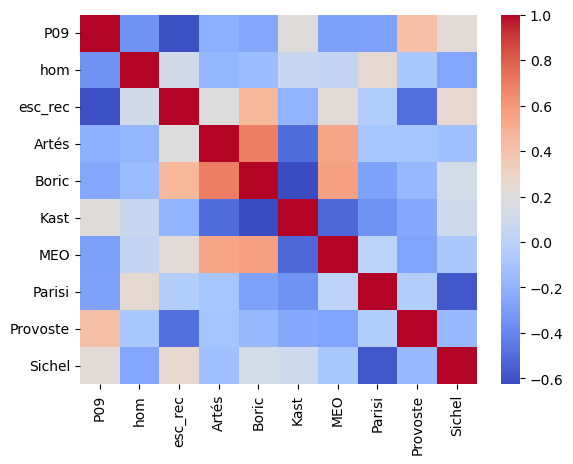

In [ ]:

sns.heatmap(corr_final, cmap='coolwarm')
plt.show()